Movie  Recommendation Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Get movie ratings

In [2]:
ratings=pd.read_csv('./ratings.csv')
movies=pd.read_csv('./movies.csv')
links=pd.read_csv('./links.csv')
tags=pd.read_csv('./tags.csv')

Implement simple recommender

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
import pickle

preprocessing dataframe

In [4]:
ratings.shape,movies.shape,links.shape, tags.shape

((100836, 4), (9742, 3), (9742, 3), (3683, 4))

In [5]:
movies.head(6)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller


In [6]:
links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
ratings.head(6)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400


In [8]:
ratings.tail(10)

,userId,movieId,rating,timestamp
100826,610,162350,3.5,1493849971
100827,610,163937,3.5,1493848789
100828,610,163981,3.5,1493850155
100829,610,164179,5.0,1493845631
100830,610,166528,4.0,1493879365
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [9]:
# calculate the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId')['userId'].count()
ratings_per_movie

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: userId, Length: 9724, dtype: int64

In [10]:
# filter for movies with more than 20 ratings and extract the movieID
popular_movies = ratings_per_movie.loc[ratings_per_movie > 20]
popular_movies

movieId
1         215
2         110
3          52
5          49
6         102
         ... 
148626     26
152081     32
164179     26
166528     27
168252     25
Name: userId, Length: 1235, dtype: int64

In [11]:
# filter the ratings matrix and only keep the popular movies
ratings = ratings.set_index('movieId').loc[popular_movies.index]
ratings = ratings.reset_index()
ratings

,movieId,userId,rating,timestamp
0,1,1,4.0,964982703
1,1,5,4.0,847434962
2,1,7,4.5,1106635946
3,1,15,2.5,1510577970
4,1,17,4.5,1305696483
...,...,...,...,...
66653,168252,567,4.0,1525283936
66654,168252,586,5.0,1529899336
66655,168252,596,5.0,1535627159
66656,168252,599,3.5,1498529615


In [12]:
# Create the users-item rating matrix
R = csr_matrix((ratings['rating'], (ratings['userId'], ratings['movieId'])))
R

<611x168253 sparse matrix of type '<class 'numpy.float64'>'
	with 66658 stored elements in Compressed Sparse Row format>

In [13]:
# e.g. user 20, movie 1 has this rating:
R[21,1]

3.5

Training/creating NMF model

In [14]:
# instantiate the unsupervised model
# 55 hidden features
model = NMF(n_components=55, init='nndsvd', max_iter=10000, tol=0.01, verbose=2)

# fit it to the user-item rating matrix
model.fit(R)

# initialzed P, Q matrix with random values
# iterate and optimize the values stored in P and Q

violation: 1.0
violation: 0.3155609469298763
violation: 0.18380282743139598
violation: 0.1391617646490206
violation: 0.11341587811317212
violation: 0.09719513724885008
violation: 0.08593978479153626
violation: 0.07887715871364313
violation: 0.07259361719286866
violation: 0.06617120082841182
violation: 0.060701962560309665
violation: 0.056025671529972745
violation: 0.05191866695914032
violation: 0.04782427574427412
violation: 0.04377751846354928
violation: 0.04018890269383427
violation: 0.03717928456332623
violation: 0.034494383083419775
violation: 0.03217689369499299
violation: 0.030117885272202015
violation: 0.02827703438535281
violation: 0.026616231189778926
violation: 0.025238847250093243
violation: 0.023890212205888425
violation: 0.02258643208642237
violation: 0.021483343438234912
violation: 0.020345905730396414
violation: 0.019294795394870258
violation: 0.018229301072144946
violation: 0.0172976737988534
violation: 0.016447320787322132
violation: 0.015533044129765047
violation: 0.0

NMF(init='nndsvd', max_iter=10000, n_components=55, tol=0.01, verbose=2)

Model inspection

In [15]:
# Calculate P and Q
# users-hidden features matrix [611x55]
P = model.transform(R)

# items-hidden features matrix [55x168253]
Q = model.components_

violation: 1.0
violation: 0.7617490374259507
violation: 0.2564425790885834
violation: 0.10392607184857196
violation: 0.048875347002261274
violation: 0.02671857165811007
violation: 0.01579042179262674
violation: 0.010061566889816315
violation: 0.0067698564935137935
Converged at iteration 10


In [16]:
# hidden features in P and Q
P.shape, Q.shape, R.shape

((611, 55), (55, 168253), (611, 168253))

The reconstruction error

In [17]:
# reconstructed matrix R, named R_hat
R_hat = np.dot(P,Q)

In [18]:
# reconstruction error
np.sqrt(np.sum(np.square(R-R_hat)))  # also available by model.reconstruction_err_

629.1201080910829

Save the trained model to the hard drive


In [19]:
with open('./nmf_recommender.pkl', 'wb') as file:
    pickle.dump(model, file)

In [20]:
ls -al *.pkl

-rw-r--r--  1 nihalbircankaya  staff  74031875 Jul 21 16:26 nmf_recommender.pkl


In [21]:
# delete variable model to make sure it is really read in again

del model
try:
    model
except NameError:
    print("There is no variable named 'model'.")

There is no variable named 'model'.


2. MODEL deployment: Make recommendations for a new user

read the model from Hard drive

In [22]:
with open('./nmf_recommender.pkl', 'rb') as file:  # This "with open" mimic is a so-called "context manager".
    model = pickle.load(file)

In [23]:
model

NMF(init='nndsvd', max_iter=10000, n_components=55, tol=0.01, verbose=2)

receive a user query

In [24]:

query = {
    # movieId, rating
    4470:5, 
    50:5,
    594:5,
    27619:5,
    152081:5,
    595:5,
    616:5,
    1029:5
}

Construct a user rating matrix R_user (only one row-only one user)

In [25]:
list(query.keys()), \
list(query.values())  

([4470, 50, 594, 27619, 152081, 595, 616, 1029], [5, 5, 5, 5, 5, 5, 5, 5])

In [26]:
# for using the csr_matrix we need 3 informations: user no., movieID, rating (data, (row_ind, col_ind))
# user number is zero. movieID and rating according to "query" dictionary.

In [27]:
data = list(query.values())   # the ratings of the new user
row_ind = [0]*len(data)       # we use just a single row 0 for this user 
col_ind = list(query.keys())  # the columns (=movieId) of the ratings

data, row_ind, col_ind

([5, 5, 5, 5, 5, 5, 5, 5],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [4470, 50, 594, 27619, 152081, 595, 616, 1029])

In [28]:
# user rating matrix needs to have the same number of columns as the training data (R) => param. shape = ...

R_user = csr_matrix((data, (row_ind, col_ind)), shape = (1, R.shape[1]))

In [29]:
R_user

<1x168253 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

Calculate the hidden features and approximated features

In [30]:
P_user = model.transform(R_user)
# Q does not change
R_recommended = np.dot(P_user, Q)

# The same result can be obtained by:
scores = model.inverse_transform(model.transform(R_user))  # R_recommended == sores

violation: 1.0
violation: 1.2420627959620363
violation: 0.02462210123112406
violation: 0.0037576439590572682
Converged at iteration 5
violation: 1.0
violation: 1.2420627959620363
violation: 0.02462210123112406
violation: 0.0037576439590572682
Converged at iteration 5


In [31]:
# convert to a pandas series
scores = pd.Series(scores[0])
scores

0         0.000000
1         0.292207
2         0.265706
3         0.028779
4         0.000000
            ...   
168248    0.000000
168249    0.000000
168250    0.000000
168251    0.000000
168252    0.037193
Length: 168253, dtype: float64

Give recommendations

In [32]:
# give a zero score to movies the user has already seen
scores[query.keys()] = 0

In [33]:
# sort the scores from high to low 
scores = scores.sort_values(ascending=False)

In [34]:
# get the movieIds of the top 15 entries
recommendations = scores.head(15).index
recommendations

Int64Index([364, 296, 858, 588, 34, 2081, 596, 551, 1221, 1073, 1028, 2078,
            1022, 3114, 919],
           dtype='int64')

In [35]:
# transform these numbers into movie names
movies = pd.read_csv('./ml-latest-small/movies.csv')

In [36]:
print('These are the top 10 recommended movies for the user')
movies.set_index('movieId').loc[recommendations]

These are the top 10 recommended movies for the user


,title,genres
364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
858,"Godfather, The (1972)",Crime|Drama
588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
34,Babe (1995),Children|Drama
2081,"Little Mermaid, The (1989)",Animation|Children|Comedy|Musical|Romance
596,Pinocchio (1940),Animation|Children|Fantasy|Musical
551,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical
1221,"Godfather: Part II, The (1974)",Crime|Drama
1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical


In [37]:
# What movies did the user previously rate with a "5"?

print("Just FYI: This was the user's rating with '5's:")
movies.set_index('movieId').loc[query.keys()]

Just FYI: This was the user's rating with '5's:


,title,genres
movieId,,
4470,Ariel (1988),Drama
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical
27619,"Lion King 1½, The (2004)",Adventure|Animation|Children|Comedy
152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy
595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
616,"Aristocats, The (1970)",Animation|Children
1029,Dumbo (1941),Animation|Children|Drama|Musical


PCA on the ratings data

In [38]:
import matplotlib.pyplot as plt

plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler

In [39]:
ratings.shape

(66658, 4)

In [40]:
ratings.columns


Index(['movieId', 'userId', 'rating', 'timestamp'], dtype='object')

In [41]:
ratings.head(6)

,movieId,userId,rating,timestamp
0,1,1,4.0,964982703
1,1,5,4.0,847434962
2,1,7,4.5,1106635946
3,1,15,2.5,1510577970
4,1,17,4.5,1305696483
5,1,18,3.5,1455209816


In [42]:
ratings.isna().sum()

movieId      0
userId       0
rating       0
timestamp    0
dtype: int64

In [43]:
ratings.info

<bound method DataFrame.info of        movieId  userId  rating   timestamp
0            1       1     4.0   964982703
1            1       5     4.0   847434962
2            1       7     4.5  1106635946
3            1      15     2.5  1510577970
4            1      17     4.5  1305696483
...        ...     ...     ...         ...
66653   168252     567     4.0  1525283936
66654   168252     586     5.0  1529899336
66655   168252     596     5.0  1535627159
66656   168252     599     3.5  1498529615
66657   168252     610     5.0  1493846352

[66658 rows x 4 columns]>

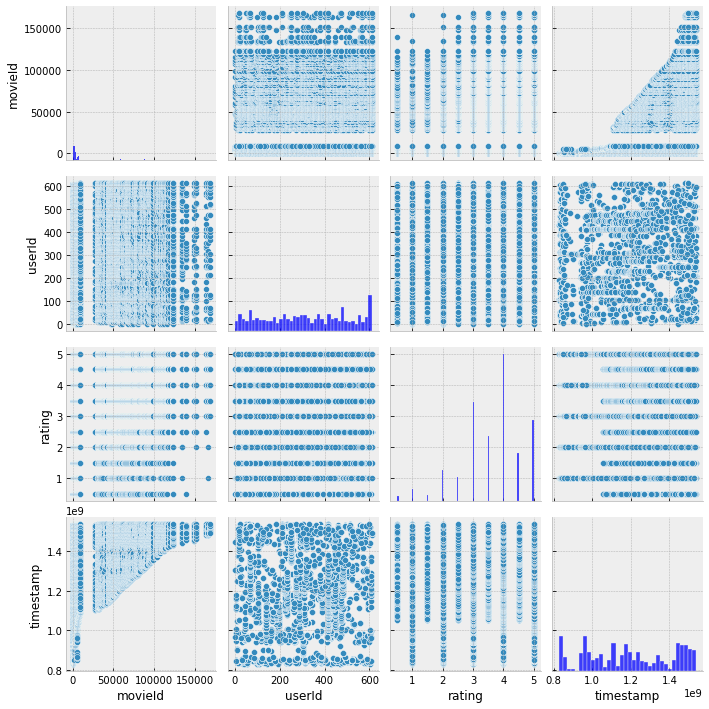

In [44]:
sns.pairplot(ratings)

<AxesSubplot:ylabel='Density'>

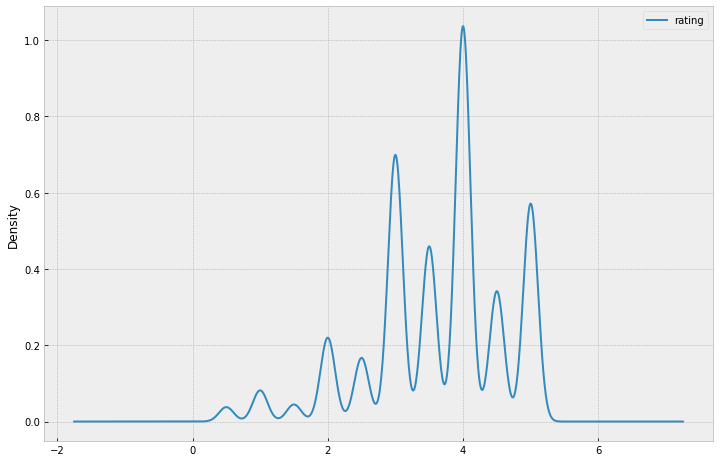

In [45]:
ratings.plot(x="movieId", y="rating", kind='density', figsize=(12,8))

<AxesSubplot:xlabel='userId', ylabel='rating'>

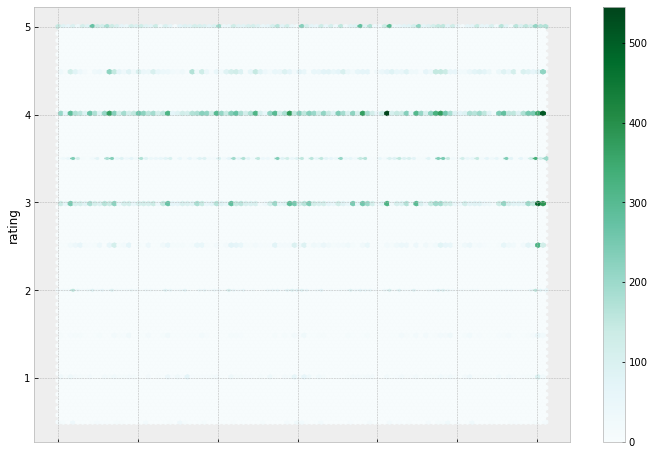

In [46]:
ratings.plot(x="userId", y="rating", kind='hexbin', figsize=(12,8))

<AxesSubplot:title={'center':'Pearson Correlation of Ratings Features'}>

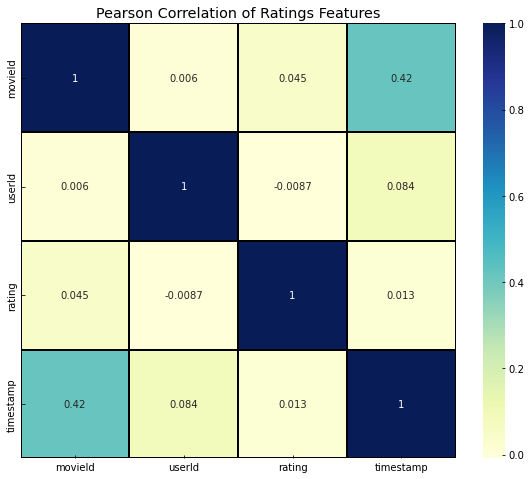

In [47]:

f, ax = plt.subplots(figsize=(10, 8))
plt.title('Pearson Correlation of Ratings Features')
sns.heatmap(ratings.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)

Normalize Data

In [48]:
raw=ratings.copy()
raw

,movieId,userId,rating,timestamp
0,1,1,4.0,964982703
1,1,5,4.0,847434962
2,1,7,4.5,1106635946
3,1,15,2.5,1510577970
4,1,17,4.5,1305696483
...,...,...,...,...
66653,168252,567,4.0,1525283936
66654,168252,586,5.0,1529899336
66655,168252,596,5.0,1535627159
66656,168252,599,3.5,1498529615


In [49]:
scaler = StandardScaler()
ratings = scaler.fit_transform(ratings)

In [50]:
ratings = pd.DataFrame(ratings, index=raw.index, columns=raw.columns)

In [51]:
ratings.head()

,movieId,userId,rating,timestamp
0,-0.476466,-1.737349,0.371443,-1.056955
1,-0.476466,-1.715294,0.371443,-1.598370
2,-0.476466,-1.704267,0.869055,-0.404512
3,-0.476466,-1.660158,-1.121391,1.456012
4,-0.476466,-1.649131,0.869055,0.512345


In [52]:
ratings.shape

(66658, 4)

Calculating Covariance Matrix

In [53]:

cov_matrix = np.cov(ratings, rowvar=False)


In [54]:
cov_matrix

array([[ 1.000015  ,  0.00596077,  0.04472361,  0.41976511],
       [ 0.00596077,  1.000015  , -0.00871237,  0.08375805],
       [ 0.04472361, -0.00871237,  1.000015  ,  0.01333384],
       [ 0.41976511,  0.08375805,  0.01333384,  1.000015  ]])

<AxesSubplot:>

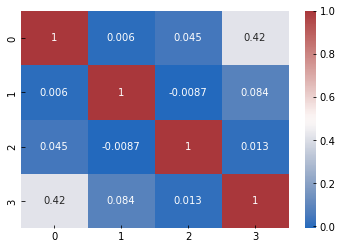

In [55]:
sns.heatmap(cov_matrix, cmap=sns.color_palette("vlag", as_cmap=True), annot=True)

In [56]:
np.dot(ratings.values.T, ratings.values)/(50-1)

array([[1360.36734694,    8.10871697,   60.83963177,  571.02618647],
       [   8.10871697, 1360.36734694,  -11.85184946,  113.94000191],
       [  60.83963177,  -11.85184946, 1360.36734694,   18.13864477],
       [ 571.02618647,  113.94000191,   18.13864477, 1360.36734694]])

Calculating Eigenvalues and Eigenvectors

In [57]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

In [58]:
eigenvalues

array([0.57209536, 0.98022122, 1.01496443, 1.432779  ])

In [59]:
eigenvectors

array([[ 0.69540023, -0.15571103,  0.11557148, -0.6919652 ],
       [ 0.12744225,  0.68629236, -0.70154135, -0.14353048],
       [-0.04809829,  0.70620681,  0.70058179, -0.09024222],
       [-0.70559447, -0.07764543, -0.06056505, -0.70174034]])

Re-calculating the CoV matrix

In [60]:
np.dot(np.dot(eigenvectors, np.diag(eigenvalues)),eigenvectors.T)

array([[ 1.000015  ,  0.00596077,  0.04472361,  0.41976511],
       [ 0.00596077,  1.000015  , -0.00871237,  0.08375805],
       [ 0.04472361, -0.00871237,  1.000015  ,  0.01333384],
       [ 0.41976511,  0.08375805,  0.01333384,  1.000015  ]])

In [61]:
eigenvectors

array([[ 0.69540023, -0.15571103,  0.11557148, -0.6919652 ],
       [ 0.12744225,  0.68629236, -0.70154135, -0.14353048],
       [-0.04809829,  0.70620681,  0.70058179, -0.09024222],
       [-0.70559447, -0.07764543, -0.06056505, -0.70174034]])

Diagonalization of matrix

In [62]:
np.cov(np.dot(ratings.values, eigenvectors), rowvar=False).round(10)

array([[ 0.57209536, -0.        ,  0.        ,  0.        ],
       [-0.        ,  0.98022122,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.01496443, -0.        ],
       [ 0.        ,  0.        , -0.        ,  1.432779  ]])

# Sort eigenvalues by size

Transformed data (all features/dimensions)

In [63]:
np.dot(ratings.values,eigenvectors);

Sort the EV

np.argsort is returning the indices of a sorted list (instead of just sorting a list)

In [64]:
sorted_index = np.argsort(eigenvalues)[::-1]

In [65]:
sorted_index

array([3, 2, 1, 0])

In [66]:
sorted_eigenvalues = eigenvalues[sorted_index]
sorted_eigenvectors = eigenvectors[:,sorted_index]

In [67]:
sorted_eigenvalues


array([1.432779  , 1.01496443, 0.98022122, 0.57209536])

In [68]:
sorted_eigenvectors

array([[-0.6919652 ,  0.11557148, -0.15571103,  0.69540023],
       [-0.14353048, -0.70154135,  0.68629236,  0.12744225],
       [-0.09024222,  0.70058179,  0.70620681, -0.04809829],
       [-0.70174034, -0.06056505, -0.07764543, -0.70559447]])

# Select eigenvectors (Percentage Variance Explained)

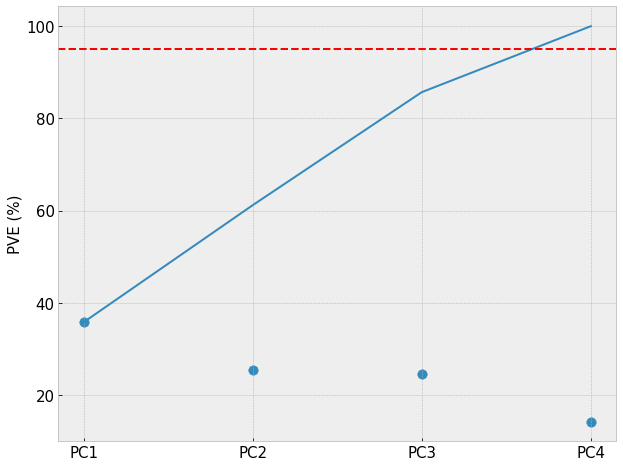

In [69]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(range(4), sorted_eigenvalues/np.sum(sorted_eigenvalues)*100, s=90)
ax.plot(range(4), [sorted_eigenvalues[0:i+1].sum()/np.sum(sorted_eigenvalues) * 100 for i, _ in enumerate(sorted_eigenvalues)])
ax.set_xticks(range(4))
ax.axhline(95, c='r', ls='--')
ax.set_xticklabels([f'PC{i+1}' for i in range(4)])
ax.set_ylabel('PVE (%)', fontsize=15)
ax.tick_params('both', labelsize=15)

Calculate loadings

In [70]:
loadings = sorted_eigenvectors*np.sqrt(sorted_eigenvalues)

In [71]:
loadings

array([[-0.82827367,  0.116433  , -0.15416345,  0.52597977],
       [-0.17180418, -0.70677094,  0.67947145,  0.09639348],
       [-0.10801881,  0.70580423,  0.69918797, -0.0363801 ],
       [-0.8399744 , -0.06101653, -0.07687373, -0.53369039]])

In [72]:
np.linalg.norm(loadings[0,:])

1.0000075010595249

# Chose number of components (2 for 2-dimensional plot)

In [73]:
n_components = 2 
eigenvector_subset = sorted_eigenvectors[:,0:n_components]

In [74]:
eigenvector_subset

array([[-0.6919652 ,  0.11557148],
       [-0.14353048, -0.70154135],
       [-0.09024222,  0.70058179],
       [-0.70174034, -0.06056505]])

Get data along PC1 and PC2

In [75]:
X_reduced = np.dot(ratings,eigenvector_subset)

In [76]:
X_reduced.shape

(66658, 2)

In [77]:
eigenvalues

array([0.57209536, 0.98022122, 1.01496443, 1.432779  ])

In [78]:
loadings

array([[-0.82827367,  0.116433  , -0.15416345,  0.52597977],
       [-0.17180418, -0.70677094,  0.67947145,  0.09639348],
       [-0.10801881,  0.70580423,  0.69918797, -0.0363801 ],
       [-0.8399744 , -0.06101653, -0.07687373, -0.53369039]])

PCA with scikit learn


In [79]:
from sklearn.decomposition import PCA

In [80]:
pca = PCA(n_components=2)

In [81]:
pca.fit(ratings)

PCA(n_components=2)

In [82]:
pca.explained_variance_ratio_.sum()

0.6119266782845235

In [83]:
print(pca.explained_variance_ratio_)

[0.35818938 0.2537373 ]
